In [25]:
# keras
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation, Embedding

# sklearn
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report, recall_score, precision_score
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.manifold import TSNE
from sklearn.externals import joblib

# Others
import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
import re

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
import matplotlib.style as style 





In [5]:
train = pd.read_csv('./Data/train.csv')

In [6]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [7]:
train.shape

(1306122, 3)

In [8]:
no_insincere = train[train['target']==1].target.count()
no_sincere = train[train['target']==0].target.count()

print('No. of insincere questions:', no_insincere)
print('No. of sincere questions:', no_sincere)
print('% of insincere questions:', train.target.mean())
print('Null score:', 1- train.target.mean())

No. of insincere questions: 80810
No. of sincere questions: 1225312
% of insincere questions: 0.06187017751787352
Null score: 0.9381298224821265


In [9]:
clean_questions = (re.sub("[^A-Za-z']+", ' ', q).lower() for q in train['question_text'])

In [10]:
stopwords = list(nltk.corpus.stopwords.words('english'))

In [11]:
%%time
# remove stop words and lower all characters
clean_questions = [' '.join(w for w in nltk.word_tokenize(q.lower()) if w not in stopwords) for q in clean_questions]

Wall time: 2min 29s


In [12]:
train['clean_question'] = list(clean_questions)

In [13]:
train.head()

,qid,question_text,target,clean_question
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,quebec nationalists see province nation
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,adopted dog would encourage people adopt shop
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,velocity affect time velocity affect space geo...
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,otto von guericke used magdeburg hemispheres
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,convert montra helicon mountain bike changing ...


In [14]:
X = train['clean_question']
y = train.target

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=495, test_size=0.2)

In [16]:
%%time
INPUT_LEN = 80

# Keep most frequent words upto vocab limit.
tokenizer = Tokenizer(num_words = 100000)
tokenizer.fit_on_texts(X_train) # assign unique feature number to each token.

Train_sequences = tokenizer.texts_to_sequences(X_train) # convert tokens in each question to feature numbers.
X_train_data = pad_sequences(Train_sequences, maxlen=INPUT_LEN) # Make all questions have the same number of features

Test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_data = pad_sequences(Test_sequences, maxlen=INPUT_LEN)


Wall time: 32.5 s


In [17]:
X_train[1]

'adopted dog would encourage people adopt shop'

In [18]:
Train_sequences[1]

[875, 2272, 21592]

In [19]:
X_train_data[1]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,   875,  2272, 21592])

In [20]:
len(tokenizer.word_counts)

163084

### LSTM model

In [23]:
# Tunning parameters
MAX_NB_WORDS = 160000
EMBEDDING_DIM = 300
LSTM_UNITS = 100
DROP = 0.2
RE_DROP = 0.2

In [24]:
## Network architecture
model = Sequential() # layers are connected sequentially, layers can only communicate with it's adjacent layer

#convert each word to a vector position based on meaning, dense representation.

model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=INPUT_LEN)) 

#dropouts randomly exclude units from activation or weight update, to reduce overfitting.
# dropout is for input layer, recurrent_dropout for internal layers.
# Dropout prevent each node to become too specialised.
model.add(LSTM(LSTM_UNITS, dropout=DROP, recurrent_dropout=RE_DROP))

model.add(Dense(1, activation='sigmoid')) # define final NN layer(output), with single node (0 or 1), sigmoid activation.
# Binary_crossentropy, for 0-1 classficiation, is a log function that punish predictions further from the actual value.
# Adam maintain per-parameter learning rate (good for sparse, NLP) and adapted learning rate based on recent changes in gradient(good for noisy data)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit the model
model.fit(X_train_data, y_train, validation_split=0.4, epochs=3)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 626938 samples, validate on 417959 samples
Epoch 1/3
626938/626938 [==============================] - 4852s 8ms/step - loss: 0.1265 - acc: 0.9509 - val_loss: 0.1176 - val_acc: 0.9537
Epoch 2/3
626938/626938 [==============================] - 5101s 8ms/step - loss: 0.1044 - acc: 0.9589 - val_loss: 0.1186 - val_acc: 0.9541
Epoch 3/3
626938/626938 [==============================] - 4824s 8ms/step - loss: 0.0909 - acc: 0.9649 - val_loss: 0.1213 - val_acc: 0.9533- loss: 0.0909 - acc: 


In [26]:
%%time
y_pred = model.predict(X_test_data, workers=6)

Wall time: 8min 56s


In [29]:
y_predRound = [ 1 if y >= 0.5 else 0  for y in y_pred]

In [30]:
print('accuracy %s' % accuracy_score(y_test, y_predRound))
print(classification_report(y_test, y_predRound))
confusion_matrix(y_test, y_predRound)

accuracy 0.9539668867834242
              precision    recall  f1-score   support

           0       0.97      0.98      0.98    245063
           1       0.67      0.50      0.57     16162

   micro avg       0.95      0.95      0.95    261225
   macro avg       0.82      0.74      0.78    261225
weighted avg       0.95      0.95      0.95    261225



array([[241087,   3976],
       [  8049,   8113]], dtype=int64)

In [34]:
confusion_matrix(y_test, y_predRound)[0][0]

241087

In [38]:
threshold_list = []
T0 = []
F1 = []
F0 = []
T1 = []
for thres in range(0, 105, 5):
    
    y_predRound = [ 1 if y >= thres/100 else 0  for y in y_pred]
    
    threshold_list.append(thres/100)
    T0.append(confusion_matrix(y_test, y_predRound)[0][0])
    F1.append(confusion_matrix(y_test, y_predRound)[0][1])
    F0.append(confusion_matrix(y_test, y_predRound)[1][0])
    T1.append(confusion_matrix(y_test, y_predRound)[1][1])



In [39]:
Confusion_Matrix = pd.DataFrame(index=threshold_list)
Confusion_Matrix['T0'] = T0
Confusion_Matrix['F1'] = F1
Confusion_Matrix['F0'] = F0
Confusion_Matrix['T1'] = T1

In [40]:
Confusion_Matrix

,T0,F1,F0,T1
0.00,0,245063,0,16162
0.05,221096,23967,2123,14039
0.10,228737,16326,3089,13073
0.15,232420,12643,3874,12288
0.20,234722,10341,4530,11632
0.25,236342,8721,5162,11000
0.30,237619,7444,5747,10415
0.35,238697,6366,6297,9865
0.40,239546,5517,6884,9278
0.45,240365,4698,7457,8705


In [43]:
Confusion_Matrix.to_pickle('LSTM2_Confusion_Matrix.pkl')

In [24]:
threshold_list = []
recall_list = []
precision_list = []
f1_list = []
for thres in range(0, 100, 5):
    
    y_predRound = [ 1 if y >= thres/100 else 0  for y in y_pred]
    threshold_list.append(thres/100)
    recall_list.append(recall_score(y_test,  y_predRound))
    precision_list.append(precision_score(y_test,  y_predRound))
    f1_list.append(f1_score(y_test,  y_predRound))

In [25]:
LSTM_combined_score = pd.DataFrame(index=threshold_list)
LSTM_combined_score['F1 Score'] = f1_list
LSTM_combined_score['Precision'] = precision_list
LSTM_combined_score['Recall'] = recall_list

In [26]:
LSTM_combined_score.to_pickle('./LSTM2_combined_score.pkl')

In [27]:
LSTM_combined_score = pd.read_pickle('./LSTM2_combined_score.pkl')

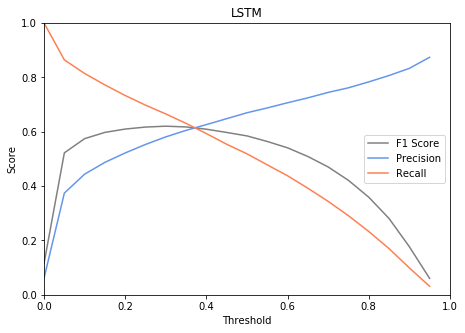

In [29]:
fig, ax = plt.subplots(figsize=(16,5))

plt.subplot(121)
sns.lineplot(x=LSTM_combined_score.index, y=LSTM_combined_score['F1 Score'], color='grey')
sns.lineplot(x=LSTM_combined_score.index, y=LSTM_combined_score['Precision'], color='cornflowerblue')
sns.lineplot(x=LSTM_combined_score.index, y=LSTM_combined_score['Recall'], color='coral')
plt.ylim(0, 1)
plt.xlim(0, 1)
# plt.xticks(rotation=45)
plt.title('LSTM')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(LSTM_combined_score.columns)




In [ ]:
model.save('./LSTM2')

### 1D convolutional layer before LSTM

In [79]:
# Tunning parameters
MAX_NB_WORDS = 50000
EMBEDDING_DIM = 100
LSTM_UNITS = 100
DROP = 0.4
RE_DROP = 0.4
FILTERS = 128
KERNEL = 1
POOL_SIZE = 2

In [80]:
%%time
def create_conv_model():
    model_conv = Sequential()
    model_conv.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=INPUT_LEN))
    model_conv.add(Dropout(DROP))
    model_conv.add(Conv1D(FILTERS, KERNEL, activation='relu'))
    model_conv.add(MaxPooling1D(pool_size=POOL_SIZE)) # Return max value from 4 adjacent values, reduce computational requirement and reduce overfitting.
    model_conv.add(LSTM(LSTM_UNITS))
    model_conv.add(Dense(1, activation='sigmoid'))
    model_conv.compile(loss='binary_crossentropy', optimizer='adam',    metrics=['accuracy'])
    return model_conv
model_conv = create_conv_model()
model_conv.fit(X_train_data, y_train, validation_split=0.4, epochs = 3)

# Reduced computation time to 1/4.

Train on 626938 samples, validate on 417959 samples
Epoch 1/3
626938/626938 [==============================] - 1991s 3ms/step - loss: 0.1290 - acc: 0.9496 - val_loss: 0.1219 - val_acc: 0.9523
Epoch 2/3
626938/626938 [==============================] - 1949s 3ms/step - loss: 0.1135 - acc: 0.9550 - val_loss: 0.1180 - val_acc: 0.9534
Epoch 3/3
626938/626938 [==============================] - 2169s 3ms/step - loss: 0.1080 - acc: 0.9575 - val_loss: 0.1212 - val_acc: 0.9530
Wall time: 1h 41min 54s


In [81]:
%%time
y_pred = model_conv.predict(X_test_data, workers=6)

Wall time: 4min 22s


In [ ]:
y_predRound = [ 1 if y >= 0.1 else 0  for y in y_pred]

In [91]:
print('accuracy %s' % accuracy_score(y_test, y_predRound))
print(classification_report(y_test, y_predRound))
confusion_matrix(y_test, y_predRound)

accuracy 0.930657479184611
              precision    recall  f1-score   support

           0       0.98      0.94      0.96    245063
           1       0.46      0.78      0.58     16162

   micro avg       0.93      0.93      0.93    261225
   macro avg       0.72      0.86      0.77    261225
weighted avg       0.95      0.93      0.94    261225



array([[230482,  14581],
       [  3533,  12629]], dtype=int64)

In [ ]:
F1_score = pd.read_excel